# Testing Hadamard MGP with GPytorch

In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import gpytorch
from matplotlib import pyplot as plt
import signatory

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
nested_dict = lambda: defaultdict(nested_dict)

def generate_dataset(n_samples=5, n_tasks=3, noise=1):
    """
    Generating Variable Length, Irregularly observed Time Series (with sine and cosine)
    Returns:
    -data dict:
        'x':
            'task_0': list of tensors
            'task_1': ..
             .. (n_tasks-1)
        'y': 
            'task_0': list of tensors
            'task_1': ..
             .. (n_tasks-1)
    list elements represent samples / instances
    """
    #determine labels (balanced)
    n_cases = int(np.floor(n_samples/2))
    n_controls = int(n_samples - n_cases)
    labels = torch.cat([torch.ones(n_cases), torch.zeros(n_controls)])
    #add signals correlated with label:
    signal = 5 #affects the frequency of the sine/cosines
    
    #first draw number of observations per sample (uniform between 20 and 50)
    lengths = torch.randint(50, 150, (n_tasks,n_samples))
    data = nested_dict()
    for i, length in enumerate(lengths): #loop over tasks
        x_list = []
        y_list = []
        for j, l in enumerate(length): #loop over samples
            x = torch.rand(l)
            if i % 2 == 0: #even tasks with sin, uneven with cos
                y = torch.sin(torch.randn(1) + x * ((5 + (signal*labels[j])*torch.randn(1))* math.pi)) + noise*torch.randn(x.size()) * 0.1
            else:
                y = torch.cos(torch.randn(1) + x * ((5+ (signal*labels[j])*torch.randn(1))* math.pi)) + noise*torch.randn(x.size()) * 0.1
            x_list.append(x)
            y_list.append(y)
        data['x']['task_' + str(i)] = x_list
        data['y']['task_' + str(i)] = y_list
    return data, labels    

## Dataset TODO:
generate synthetic data in following format:
list of per-instance tuples: [ (data, label), .. ()]
data = (times (n_timepoints) , values (n_timepoints, n_dims))
--> Unobserved points are NaNs
Write collate_fn which takes this format and compiles the triple: inputs, indices, values (per batch)

In [322]:
from torch.utils.data import Dataset

In [323]:
class SyntheticData(Dataset):
    def __init__(self, n_samples=500, n_tasks=3):
        """
        Generate synthetic data when initializing
        """
        super().__init__()
        self.data, self.labels = generate_dataset(n_samples, n_tasks)
        
        #prepare data for hadamard GP setup (decompose into inputs (times), task indices and observed values)
        self.inputs, self.values, self.indices = prepare_train_data(self.data)

    def __len__(self):
        return self.values.shape[0]

    def __getitem__(self, idx):
        return self.values[idx]
    

In [324]:
syn_dat = SyntheticData()

In [4]:
from collections import defaultdict
nested_dict = lambda: defaultdict(nested_dict)

In [5]:
def generate_test_points(n_samples=5, n_tasks=3, n_query=51):
    inputs = torch.linspace(0, 1, n_query)
    
    def get_indices(data,fill=0):
        return torch.full_like(data, dtype=torch.long, fill_value=fill)
    indices = torch.stack(
                   [ torch.cat(
                        [get_indices(inputs, i) for i in np.arange(n_tasks)]
                    ) for j in np.arange(n_samples)
                   ]
    ) 
    
    inputs = inputs.repeat(n_samples,n_tasks)

    #add extra dimension for GPytorch:
    inputs = inputs.unsqueeze(-1)
    indices = indices.unsqueeze(-1)
    return inputs, indices


In [6]:
n_samples=20
n_tasks=3
data,labels = generate_dataset(n_samples=n_samples, n_tasks=n_tasks, noise=3)

In [7]:
n_query=51
test_inputs, test_indices = generate_test_points(n_samples=n_samples, n_tasks=n_tasks, n_query=n_query)

In [8]:
def plot_data(data):
    n_samples = len(data['x']['task_0'])
    fs = int(n_samples)
    n_tasks = len(list(data['x'].keys()))
    fig, ax = plt.subplots(n_samples, figsize=(fs,fs))
    for i in np.arange(n_samples):
        for j in np.arange(n_tasks):  
            x = data['x']['task_'+str(j)][i]
            y = data['y']['task_'+str(j)][i]
            ax[i].plot(x,y, 'o')

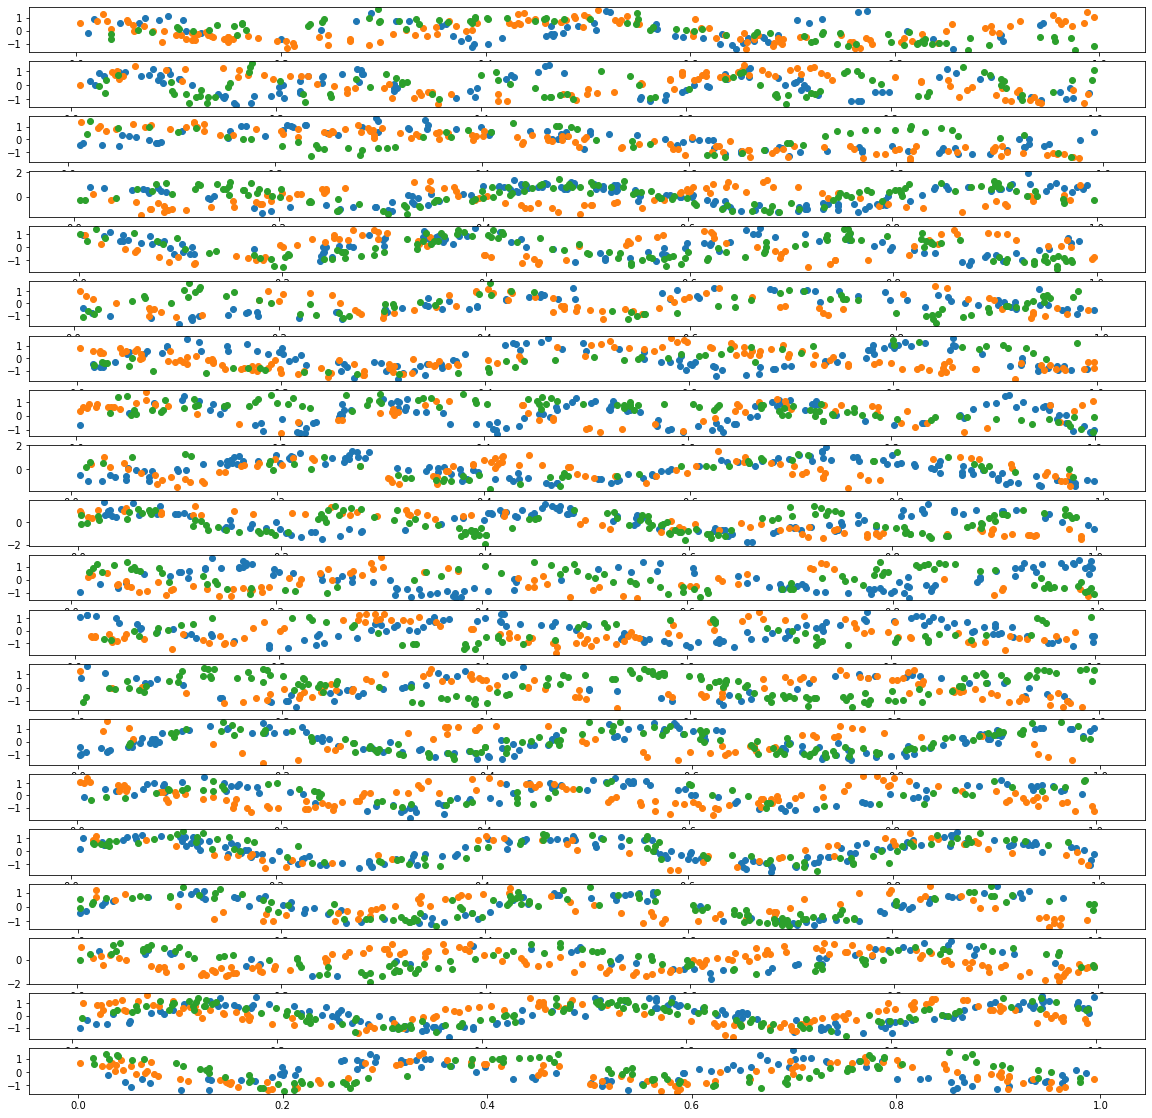

In [9]:
plot_data(data) 

In [10]:
def pad_data(data_list, fill=0):
    """
    Pad tensors with fill-value such that list of variable shaped tensors can be stacked
    """
    n_samples = len(data_list)
    #first determine longest time series:
    lengths = [x.shape[0] for x in data_list]
    max_len = max(lengths)
    
    output = fill*torch.ones((n_samples, max_len))
    for i in np.arange(n_samples):
        output[i,:lengths[i]] = data_list[i]
    return output
        

In [11]:
def merge_tasks(data):
    """
    For GPyTorch MGP, the tasks need to be merged into one tensor, and a index tensor identifies the task at hand
    Inputs:
    - data: nested dictionary, from generate_dataset()
    Returns:
    - x: [n_samples, len_all_tasks]
    - y: [n_samples, len_all_tasks] 
    - task_indices: [n_samples, len_all_tasks] 
    
    """
    n_samples = len(data['x']['task_0'])
    n_tasks = len(list(data['x'].keys()))
    
    #first determine maximal length of all tasks
    inputs_samples = [] # as final output size is not known here, we append all data to list..
    values_samples = []
    indices_samples = [] 
   
    for i in np.arange(n_samples):
        indices_list = []
        inputs_list = []
        values_list = []
        for j in np.arange(n_tasks):
            x = data['x']['task_' + str(j)][i]
            y = data['y']['task_'+str(j)][i]
            task_index = torch.full_like(x, dtype=torch.long, fill_value=j)
            #Append data per task into one list, and then concatenate it
            inputs_list.append(x)
            values_list.append(y)
            indices_list.append(task_index)
        #Get tensor of current sample
        inputs = torch.cat(inputs_list)
        values = torch.cat(values_list)
        indices = torch.cat(indices_list)

        #Append all tensors to list over samples
        inputs_samples.append(inputs)
        values_samples.append(values)
        indices_samples.append(indices)
    
    return  pad_data(inputs_samples), pad_data(values_samples), pad_data(indices_samples,fill=n_tasks).to(dtype=torch.long)
    #we pad the task indices with 99 as an exotic number, to not mix it up with real tasks
    

In [11]:
inputs, values, indices = merge_tasks(data)


In [12]:
# GPyTorch seems to require additional dim for inputs
inputs = inputs.unsqueeze(-1)
indices = indices.unsqueeze(-1)

In [12]:
def prepare_train_data(data):
    inputs, values, indices = merge_tasks(data)
    inputs = inputs.unsqueeze(-1)
    indices = indices.unsqueeze(-1)
    return inputs, values, indices

In [13]:
inputs, values, indices = prepare_train_data(data)

torch.Size([50, 153, 1])

# MGP Model

In [14]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks=2):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank=3)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)

likelihood = gpytorch.likelihoods.GaussianLikelihood()

### try out set_train_data() with synthetic data to ensure that new batch inputs + values are used for posterior distribution!

In [15]:
#start MGP layer for MGP-Sig adapter:
class MGP_Layer(MultitaskGPModel):
    def __init__(self,likelihood, num_tasks=2):
        super().__init__(None, None, likelihood, num_tasks) 
        #we don't intialize with train data for more flexibility
        likelihood.train()
        
    def forward(self, inputs, indices):
        return super(MGP_Layer, self).forward(inputs, indices)
    
    def condition_on_train_data(self, inputs, indices, values):
        self.set_train_data(inputs=(inputs, indices), targets=values, strict=False)

In [17]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(*self.shape)

In [16]:
class SimpleDeepModel(nn.Module):
    def __init__(self, n_input_dims):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input_dims, 100),
            nn.ReLU(True),
            nn.Linear(100, 2),
            nn.ReLU(True)
        )
    def forward(self, x):
        return self.model(x)

In [151]:
class DeepSignatureModel(nn.Module):
    def __init__(self, in_channels, out_dimension=2, sig_depth=3):
        super().__init__()
        self.augment1 = signatory.Augment(in_channels=in_channels,
                                          layer_sizes=(8, 8, 4),
                                          kernel_size=4,
                                          include_original=True,
                                          include_time=True)
        self.signature1 = signatory.Signature(depth=sig_depth,
                                              stream=True)

        # +5 because self.augment1 is used to add time, and 4 other
        # channels, as well
        sig_channels1 = signatory.signature_channels(channels=in_channels + 5,
                                                     depth=sig_depth)
        self.augment2 = signatory.Augment(in_channels=sig_channels1,
                                          layer_sizes=(8, 8, 4),
                                          kernel_size=4,
                                          include_original=False,
                                          include_time=False)
        self.signature2 = signatory.Signature(depth=sig_depth,
                                              stream=False)

        # 4 because that's the final layer size in self.augment2
        sig_channels2 = signatory.signature_channels(channels=4,
                                                     depth=sig_depth)
        self.linear = torch.nn.Linear(sig_channels2, out_dimension)
        #self.model = nn.Sequential(
        #    nn.Linear(n_input_dims, 100),
        #    nn.ReLU(True),
        #    nn.Linear(100, 2),
        #    nn.ReLU(True)
        #)
    def forward(self, x):
        # in docu: input is a three dimensional tensor of shape (batch, stream, in_channels)
        a = self.augment1(x)
        if a.size(-2) <= 1:
            raise RuntimeError("Given an input with too short a stream to take the"
                               " signature")
        # a is a three dimensional tensor of shape (batch, stream, in_channels + 5)
        b = self.signature1(a, basepoint=True)
        # b is a three dimensional tensor of shape (batch, stream, sig_channels1)
        c = self.augment2(b)
        if c.size(-2) <= 1:
            raise RuntimeError("Given an input with too short a stream to take the"
                               " signature")
        # c is a three dimensional tensor of shape (batch, stream, 4)
        d = self.signature2(c, basepoint=True)
        # d is a two dimensional tensor of shape (batch, sig_channels2)
        e = self.linear(d)
        # e is a two dimensional tensor of shape (batch, out_dimension)
        return e

In [152]:
class GPAdapter(nn.Module):
    def __init__(self, n_input_dims, n_mc_smps, *gp_params):
        super(GPAdapter, self).__init__()
        self.n_mc_smps = n_mc_smps
        self.n_tasks = [*gp_params][-1] -1 #num_tasks includes dummy task for padedd zeros
        self.mgp = MGP_Layer(*gp_params)
        self.clf = DeepSignatureModel(self.n_tasks)
        
    def forward(self, *data):
        """
        The GP Adapter takes input data as a list of 5 torch tensors (3 for train points, 2 for prediction points)
            - inputs: input points of time grid (batch, timesteps, 1)
            - indices: indices of task or channels (batch, timesteps, 1)
            - values: values (or targets) of actual observations (batch, timesteps)
            - test_inputs: query points in time (batch, timesteps, 1)
            - test_indices: query tasks for given point in time (batch, timesteps, 1)
        """
        
        self.posterior = self.gp_forward(*data)
        #draw sample in MGP format (all tasks in same dimension)
        Z = self.draw_samples(self.posterior, self.n_mc_smps)
        #reshape such that tensor has timesteps and tasks/channels in independent dimensions for Signature network:
        Z = self.channel_reshape(Z)
        return self.clf(Z)
                
    def gp_forward(self, *data):
        #Unpack data:
        inputs, indices, values, test_inputs, test_indices = [*data]
        
        #Condition MGP on training data:
        self.mgp.condition_on_train_data(inputs, indices, values)

        #Return posterior distribution:
        return self.mgp(test_inputs, test_indices)

    def draw_samples(self, posterior, n_mc_smps):
        #Draw monte carlo samples (with gradient) from posterior:
        return posterior.rsample(torch.Size([n_mc_smps])) #mc_samples form a new (outermost) dimension
        
    def parameters(self):
        return list(self.mgp.parameters()) + list(self.clf.parameters())
        
    def train(self, mode=True):
        """
        only set classifier to train mode, MGP always in eval mode for posterior draws
        """
        if mode:
            super().train()
            self.mgp.eval()
        else: 
            super().train(False)
            
    def eval(self):
        """
        eval simply calls eval of super class (which in turn activates train with False)
        """
        super().eval()
        
    def channel_reshape(self, X):
        X_reshaped = X.view(X.shape[:-1] 
                            + torch.Size([self.n_tasks]) 
                            + torch.Size([int(X.shape[-1] / self.n_tasks)]) 
                           )
        # finally, swap last two dims: timestep and channel dim for Signature Augmentations
        X_reshaped = X_reshaped.transpose(-2,-1)
        X_reshaped = X_reshaped.flatten(0,1) #SigNet requires 3 dim setup, so we flatten out the mc dimension with batch
        return X_reshaped

In [18]:
def augment_labels(labels, n_samples):
    """
    Function to expand labels for multiple MC samples in the GP Adapter 
        - takes tensor of size [n]
        - returns expanded tensor of size [n_mc_samples, n]
    """
    return labels.unsqueeze(-1).expand(labels.shape[0],n_samples).transpose(1,0)

## Training a simple MGP Adapter

In [153]:
from sklearn.metrics import roc_auc_score as auc

# Training Parameters:
n_epochs = 50

# Setting up parameters of GP:
n_mc_smps = 10
n_input_dims = test_inputs.shape[1]
num_tasks=n_tasks+1 #augment tasks with dummy task for imputed 0s for tensor format
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#likelihood.eval()

# Initializing GP adapter model (for now assuming imputing to equal length time series)
model = GPAdapter(n_input_dims, n_mc_smps, likelihood, num_tasks)

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()}, 
], lr=0.01)

# Loss function:
loss_fn = nn.CrossEntropyLoss(reduction='mean')

for i in np.arange(n_epochs): #for test trial, overfit same batch of samples
    #augment labels:
    y_true = augment_labels(labels, n_mc_smps)
    
    #activate training mode of deep model:
    model.train()
    
    #forward pass:
    #with gpytorch.settings.fast_pred_samples(): 
    with gpytorch.settings.fast_pred_var():
        logits = model(inputs, indices, values, test_inputs, test_indices) 
    
    #evaluate loss
    loss = loss_fn(logits, y_true.long().flatten()) #logits.flatten(0,1)
    
    #Optimize:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        AUROC = auc(y_true.long().flatten().detach().numpy(),logits[:,1].flatten().detach().numpy()) #logits[:,:,1]
        print(f'Epoch {i}, Train Loss: {loss.item():03f}  Train AUC: {AUROC:03f}')

Epoch 0, Train Loss: 0.694781  Train AUC: 0.705500
Epoch 1, Train Loss: 0.684996  Train AUC: 0.869000
Epoch 2, Train Loss: 0.668342  Train AUC: 0.871000
Epoch 3, Train Loss: 0.635342  Train AUC: 0.894900
Epoch 4, Train Loss: 0.578210  Train AUC: 0.911500
Epoch 5, Train Loss: 0.519172  Train AUC: 0.904800
Epoch 6, Train Loss: 0.438225  Train AUC: 0.904200
Epoch 7, Train Loss: 0.375272  Train AUC: 0.911200
Epoch 8, Train Loss: 0.338617  Train AUC: 0.926000
Epoch 9, Train Loss: 0.347318  Train AUC: 0.939100
Epoch 10, Train Loss: 0.338862  Train AUC: 0.940300
Epoch 11, Train Loss: 0.301304  Train AUC: 0.937800
Epoch 12, Train Loss: 0.246405  Train AUC: 0.964000
Epoch 13, Train Loss: 0.240689  Train AUC: 0.965500
Epoch 14, Train Loss: 0.233669  Train AUC: 0.967700
Epoch 15, Train Loss: 0.232912  Train AUC: 0.972400
Epoch 16, Train Loss: 0.191324  Train AUC: 0.987500
Epoch 17, Train Loss: 0.207697  Train AUC: 0.975900
Epoch 18, Train Loss: 0.190752  Train AUC: 0.981200
Epoch 19, Train Loss: 

In [136]:
posterior = model.gp_forward(inputs, indices, values, test_inputs, test_indices) 
dummy = posterior.sample(torch.Size([5]))
dummy.shape

torch.Size([5, 20, 153])

torch.Size([200, 2])

In [90]:
dummy = test_indices.squeeze() #[0].flatten()

In [138]:
dummy.flatten(0,1).shape

torch.Size([100, 153])

In [123]:
dummy_reshaped = dummy.view(dummy.shape[:-1] + torch.Size([n_tasks]) + torch.Size([int(dummy.shape[-1]/n_tasks)]))

In [124]:
dummy_ = dummy_reshaped.transpose(-2,-1) # swap timestep and channel dim for Signature Net!

In [125]:
dummy_.shape

torch.Size([5, 20, 51, 3])

In [103]:
# Here we have two iterms that we're passing in as train_inputs
#model = MultitaskGPModel((inputs, indices), values, likelihood, num_tasks=n_tasks+1)

#model = MultitaskGPModel(None, None, likelihood, num_tasks=n_tasks+1)
model = MGP_Layer(likelihood, num_tasks=n_tasks+1) 

In [104]:
# Find optimal model hyperparameters
model.train() 
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    #model.update_data(inputs=(inputs, indices), targets=values)
    model.set_train_data(inputs=(inputs, indices), targets=values, strict=False)
    optimizer.zero_grad()
    output = model(inputs, indices)
    loss = -mll(output, values).mean()
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.088
Iter 2/50 - Loss: 1.068
Iter 3/50 - Loss: 1.049
Iter 4/50 - Loss: 1.032
Iter 5/50 - Loss: 1.016
Iter 6/50 - Loss: 1.001
Iter 7/50 - Loss: 0.988
Iter 8/50 - Loss: 0.974
Iter 9/50 - Loss: 0.957
Iter 10/50 - Loss: 0.937
Iter 11/50 - Loss: 0.908
Iter 12/50 - Loss: 0.872
Iter 13/50 - Loss: 0.827
Iter 14/50 - Loss: 0.779
Iter 15/50 - Loss: 0.728
Iter 16/50 - Loss: 0.685
Iter 17/50 - Loss: 0.647
Iter 18/50 - Loss: 0.614
Iter 19/50 - Loss: 0.584
Iter 20/50 - Loss: 0.565
Iter 21/50 - Loss: 0.545
Iter 22/50 - Loss: 0.514
Iter 23/50 - Loss: 0.503
Iter 24/50 - Loss: 0.490
Iter 25/50 - Loss: 0.480
Iter 26/50 - Loss: 0.479
Iter 27/50 - Loss: 0.477
Iter 28/50 - Loss: 0.471
Iter 29/50 - Loss: 0.475
Iter 30/50 - Loss: 0.484
Iter 31/50 - Loss: 0.489
Iter 32/50 - Loss: 0.498
Iter 33/50 - Loss: 0.509
Iter 34/50 - Loss: 0.508
Iter 35/50 - Loss: 0.498
Iter 36/50 - Loss: 0.495
Iter 37/50 - Loss: 0.495
Iter 38/50 - Loss: 0.482
Iter 39/50 - Loss: 0.476
Iter 40/50 - Loss: 0.459
Iter 41/5

In [16]:
# Train MGP Layer:
model.train() 
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    #model.update_data(inputs=(inputs, indices), targets=values)
    model.condition_on_train_data(inputs, indices, values)
    optimizer.zero_grad()
    output = model(inputs, indices)
    loss = -mll(output, values).mean()
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.088
Iter 2/50 - Loss: 1.072
Iter 3/50 - Loss: 1.056
Iter 4/50 - Loss: 1.041
Iter 5/50 - Loss: 1.026
Iter 6/50 - Loss: 1.013
Iter 7/50 - Loss: 1.000
Iter 8/50 - Loss: 0.986
Iter 9/50 - Loss: 0.971
Iter 10/50 - Loss: 0.952
Iter 11/50 - Loss: 0.926
Iter 12/50 - Loss: 0.890
Iter 13/50 - Loss: 0.842
Iter 14/50 - Loss: 0.784
Iter 15/50 - Loss: 0.730
Iter 16/50 - Loss: 0.685
Iter 17/50 - Loss: 0.651
Iter 18/50 - Loss: 0.618
Iter 19/50 - Loss: 0.580
Iter 20/50 - Loss: 0.540
Iter 21/50 - Loss: 0.512
Iter 22/50 - Loss: 0.478
Iter 23/50 - Loss: 0.465
Iter 24/50 - Loss: 0.445
Iter 25/50 - Loss: 0.420
Iter 26/50 - Loss: 0.412
Iter 27/50 - Loss: 0.397
Iter 28/50 - Loss: 0.409
Iter 29/50 - Loss: 0.419
Iter 30/50 - Loss: 0.418
Iter 31/50 - Loss: 0.421
Iter 32/50 - Loss: 0.433
Iter 33/50 - Loss: 0.444
Iter 34/50 - Loss: 0.449
Iter 35/50 - Loss: 0.452
Iter 36/50 - Loss: 0.446
Iter 37/50 - Loss: 0.449
Iter 38/50 - Loss: 0.442
Iter 39/50 - Loss: 0.435
Iter 40/50 - Loss: 0.433
Iter 41/5

In [132]:
output.rsample(torch.Size([3])).shape

torch.Size([3, 10, 325])

In [183]:
obj = likelihood(model(inputs,indices))

In [125]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions - one task at a time
# We control the task we cae about using the indices

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
#with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #observed_pred_y1 = likelihood(model(test_x, test_i_task1))
    #dummy = torch.sum(likelihood(model(test_inputs, test_indices)).mean)
    #dummy.backward() 
    observed_pred_y = likelihood(model(test_inputs, test_indices))

In [172]:
# model.zero_grad()
model.covar_module.raw_lengthscale.grad

tensor([[-269.7131]])

(tensor([[-2.7246e+04, -5.1546e+04,  6.1281e+04,  ...,  1.8324e+04,
          -2.8152e+03,  2.4148e+03],
         [ 2.7463e+04,  1.0999e+04,  3.9659e+04,  ..., -6.8586e+03,
           2.4551e+04,  1.9623e+04],
         [ 3.7105e+05,  1.6998e+05,  1.0199e+04,  ...,  2.4419e+04,
          -1.0439e+04,  3.3963e+04],
         ...,
         [-3.3661e+00, -5.4537e-01, -7.1001e-01,  ..., -2.5047e+00,
           6.3184e-01,  1.9823e+00],
         [-7.9858e+04, -1.1307e+04,  6.0891e+04,  ...,  1.2760e+04,
           3.7473e+02, -1.4862e+04],
         [ 1.7888e+05,  3.6233e+04, -3.9535e+04,  ..., -6.0309e+04,
          -1.3425e+05, -2.7294e+04]], grad_fn=<SubBackward0>),
 tensor([[-2.7241e+04, -5.1544e+04,  6.1284e+04,  ...,  1.8326e+04,
          -2.8138e+03,  2.4172e+03],
         [ 2.7465e+04,  1.1001e+04,  3.9661e+04,  ..., -6.8564e+03,
           2.4553e+04,  1.9625e+04],
         [ 3.7105e+05,  1.6998e+05,  1.0201e+04,  ...,  2.4421e+04,
          -1.0437e+04,  3.3967e+04],
         ...,
 

In [126]:
def extract_train_data(data, indices, sample, task):
    """
    Utiliy function to extract data (values or inputs) of tensor for a single sample and task
    """
    return data.squeeze()[sample,:][indices.squeeze()[sample,:] == task]


def extract_test_data(data, n_query, sample, task):
    return data[sample,n_query*(task):n_query*(task+1)]

Text(0.5, 1.0, 'GPyTorch Hadamard MGP with global parameters (shared over samples)')

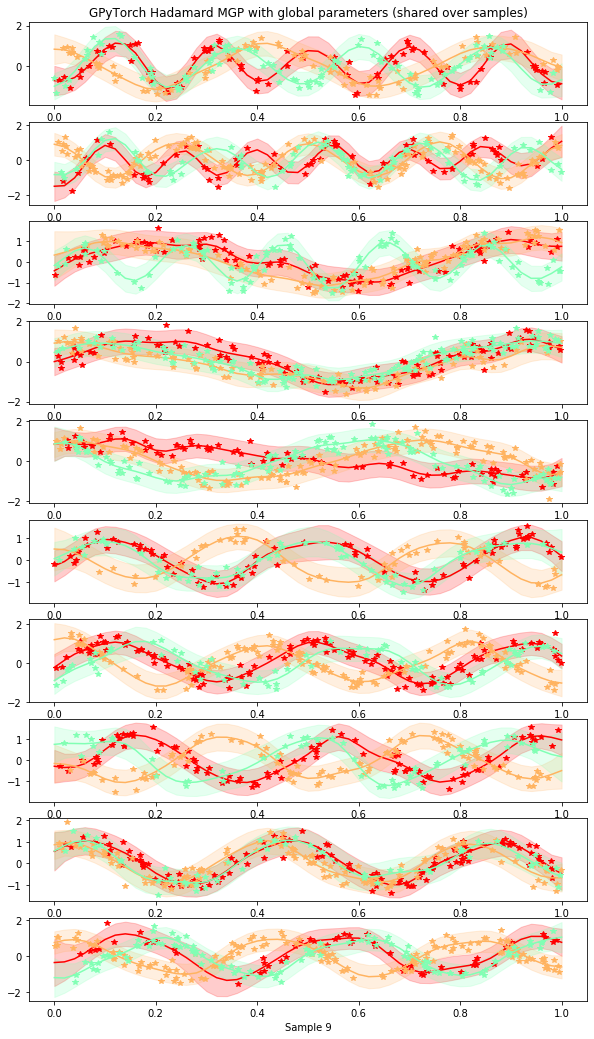

In [131]:
from matplotlib.pyplot import cm
colors=cm.rainbow(np.linspace(1,0,n_tasks+2))

# Initialize plots
f, ax = plt.subplots(n_samples, figsize=(10, 18))

# Unpack predictions:
mean = observed_pred_y.mean #try out random samples with: mean = observed_pred_y.sample(torch.Size([3]))[2]
lower, upper = observed_pred_y.confidence_region()

for i in np.arange(n_samples):
    for j in np.arange(n_tasks):
        # Plot training data as black stars
        #get train input data of current sample and task:
        train_x = extract_train_data(inputs, indices, i, j)
        train_y = extract_train_data(values, indices, i, j)
        #Plot train data (irregularly observed)
        ax[i].plot(train_x.detach().numpy(), train_y.detach().numpy(), '*', c=colors[j])
        
        test_x = extract_test_data(test_inputs.squeeze(), n_query, i, j)
        test_y_mean = extract_test_data(mean, n_query, i, j)
        
        ax[i].plot(test_x.detach().numpy(), test_y_mean.detach().numpy(), 'b', c=colors[j]) #, 'b'
        
        test_y_lower = extract_test_data(lower, n_query, i, j)
        test_y_upper = extract_test_data(upper, n_query, i, j)
        
        ax[i].fill_between(test_x.detach().numpy(), test_y_lower.detach().numpy(), test_y_upper.detach().numpy(), alpha=0.2, color=colors[j])
        
        ax[i].set_xlabel(f'Sample {i}')
ax[0].set_title('GPyTorch Hadamard MGP with global parameters (shared over samples)')

In [204]:
f.savefig('plots/hadamard_MGP.pdf')

FileNotFoundError: [Errno 2] No such file or directory: 'plots/hadamard_MGP.pdf'

In [242]:
for param_name, param in model.named_parameters():
    print(f'Name: {param_name} Value = {param.data}')

Name: likelihood.noise_covar.raw_noise Value = tensor([-5.5567])
Name: mean_module.constant Value = tensor([0.0436])
Name: covar_module.raw_lengthscale Value = tensor([[-4.5031]])
Name: task_covar_module.covar_factor Value = tensor([[-0.1763,  0.0035, -0.1297],
        [-0.0261,  0.1377, -0.0258],
        [-0.1691,  0.2356,  0.0567],
        [ 0.0633, -0.0598, -0.0617]])
Name: task_covar_module.raw_var Value = tensor([-1.2762, -0.9626, -1.6848, -5.6450])


<generator object Module.parameters at 0x129383250>

In [29]:
test_x = torch.linspace(0, 1, 51).repeat(4,1).unsqueeze(-1)

In [30]:
test_x.shape

torch.Size([4, 51, 1])

In [ ]:
# Initialize plots
f, ax = plt.subplots(n_samples, figsize=(20, 15))

n_tasks = train_y.shape[-1]
for i in np.arange(n_samples):
    for j in np.arange(n_tasks):
        # Plot training data as black stars
        ax[i,j].plot(train_x[i].detach().numpy(), train_y[i,:,j].detach().numpy(), 'k*')
        
        # Predictive mean as blue line
        ax[i,j].plot(test_x[i].numpy(), mean[i,:,j].numpy(), 'b')
        # Shade in confidence
        ax[i,j].fill_between(test_x[i].numpy().squeeze(), lower[i,:,j].numpy(), upper[i,:,j].numpy(), alpha=0.5)
        #ax[i,j].set_ylim([-3, 3])
        #ax[i,j].legend(['Observed Data', 'Mean', 'Confidence'])
        #ax[i,j].set_title('Observed Values (Likelihood)')


In [147]:
Train_x = train_x.unsqueeze(0).repeat(4,1)

In [212]:
shifts = torch.tensor([1,-0.5,0,0.7]).unsqueeze(-1)
frequencies = torch.tensor([2,0.5,3,1]).unsqueeze(-1)

In [231]:
Train_y = torch.stack([
    torch.sin(Train_x * (2*frequencies* math.pi) + shifts ) + torch.randn(Train_x.size()) * 0.2,
    torch.cos(Train_x * (3*frequencies* math.pi) + shifts ) + torch.randn(Train_x.size()) * 0.2,
], -1)

In [244]:
a = torch.tensor(float('nan')) 

In [249]:
Train_y[0,0,0] = float('nan')

In [252]:
def plot_data(Train_x, Train_y):
    n_samples = Train_x.shape[0]
    fig, ax = plt.subplots(n_samples, figsize=(10,10))
    for i, (x,y) in enumerate(zip(Train_x, Train_y)):
        ax[i].plot(x,y)
        

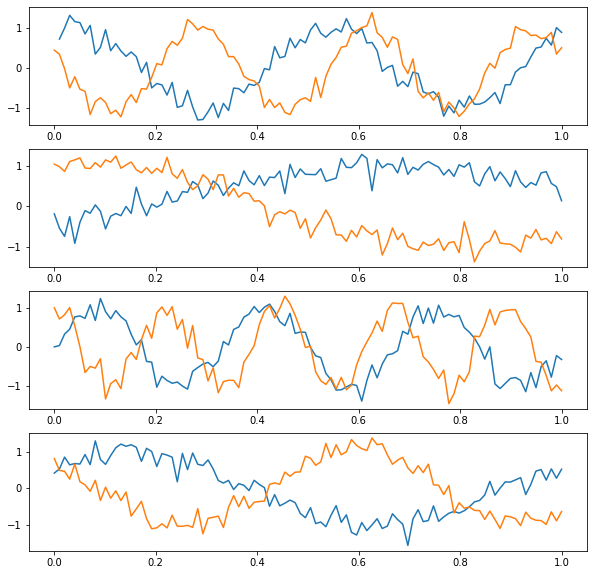

In [253]:
plot_data(Train_x, Train_y)

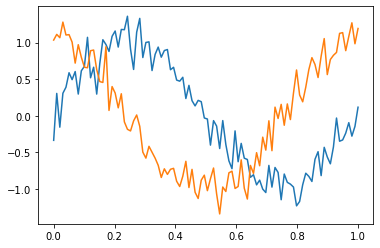

In [142]:
plt.plot(train_x, train_y)

# Kronecker MGP here

In [92]:
#MGP Model Class
class MultitaskGPModel(gpytorch.models.ExactGP ):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)



In [254]:
train_x = Train_x
train_y = Train_y

In [255]:
train_x = train_x.unsqueeze(-1)

In [256]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [257]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y).mean() #.mean()
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

RuntimeError: NaNs encounterd when trying to perform matrix-vector multiplication

In [241]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51).unsqueeze(0).repeat(4,1).unsqueeze(-1)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task


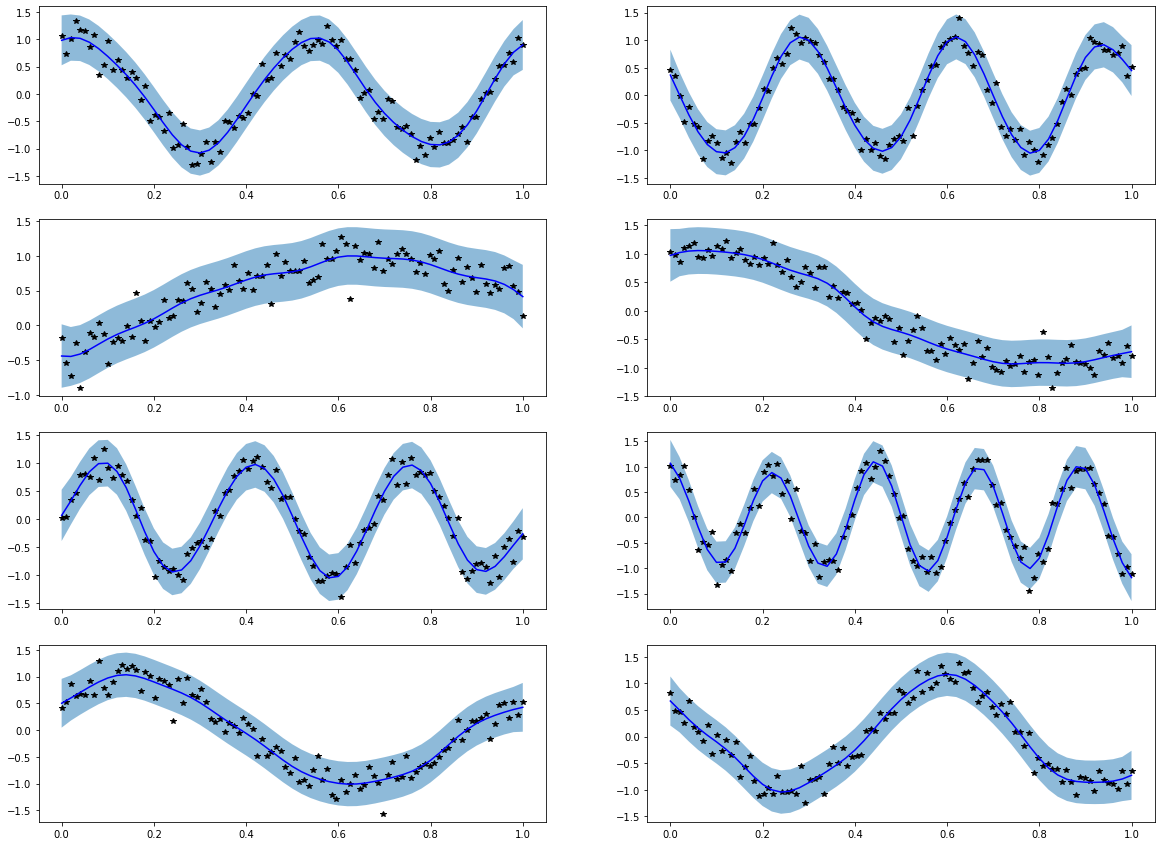

In [242]:
# Initialize plots
f, ax = plt.subplots(4, 2, figsize=(20, 15))

n_samples = test_x.shape[0]
n_tasks = train_y.shape[-1]
for i in np.arange(n_samples):
    for j in np.arange(n_tasks):
        # Plot training data as black stars
        ax[i,j].plot(train_x[i].detach().numpy(), train_y[i,:,j].detach().numpy(), 'k*')
        
        # Predictive mean as blue line
        ax[i,j].plot(test_x[i].numpy(), mean[i,:,j].numpy(), 'b')
        # Shade in confidence
        ax[i,j].fill_between(test_x[i].numpy().squeeze(), lower[i,:,j].numpy(), upper[i,:,j].numpy(), alpha=0.5)
        #ax[i,j].set_ylim([-3, 3])
        #ax[i,j].legend(['Observed Data', 'Mean', 'Confidence'])
        #ax[i,j].set_title('Observed Values (Likelihood)')


(51,)

In [ ]:
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')